In [1]:
# script to calculate correlations between degree and tissue-preferential expression or 
# betweenness and tissue-preferential expression

# use networks filtered to only contain edges between genes observed to be expressed in the same tissue
# restrict networks to LCC (largest connected component)
# use the max TiP value as a measure of tissue-preferential expression for every gene

In [2]:
import os

import pickle
import numpy as np
import pandas, numpy, scipy.stats, igraph
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

matplotlib.rcParams['pdf.fonttype'] = 42

expr_cutoff = 5

data_path = '/Volumes/mvidal/homes/kl593/HuRI/Analysis/GTEx/analysis_GTExV6_2018_frozen/'
outpath = '../figures'

network_names = ['Lit-BM-17','BioPlex','QUBIC','CoFrac','HI-I-05','HI-II-14','HI-III']
figure_network_names = ['Lit-BM','BioPlex','QUBIC','CoFrac','HI-I-05','HI-II-14','HI-III-19']
colors = [(60/255, 134/255, 184/255),'#e6550d','#fd8d3c','#fdbe85','pink','orchid',(155/255, 97/255, 153/255)]

In [3]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500
HURI_COLOR = (155 / 255, 97 / 255, 153 / 255)
LIT_COLOR = (60 / 255, 134 / 255, 184 / 255)
# from colorbrewer; middle three of 5-class purples
ASSAY_V1_COLOR = '#cbc9e2'
ASSAY_V2_COLOR = '#9e9ac8'
ASSAY_V3_COLOR = '#756bb1'
HI_I_05_COLOR = 'pink'
HI_II_14_COLOR = 'orchid'
RRS_COLOR = (224 / 255, 16 / 255, 28 / 255)
# from colorbrewer; middle three of 5-class oranges
BIOPLEX_COLOR = '#e6550d'
QUBIC_COLOR = '#fd8d3c'
COFRAC_COLOR = '#fdbe85'
FORMATS = ['.pdf', '.png']

In [4]:
# read in the collapsed CSNs (condition-specific networks) for each source network
networks = []
for network_name in network_names:
    pickle_file = data_path + network_name + '/GTExv6_collapsed_CSN_' + network_name + '_no_testis.pickle'
    networks.append(pickle.load(open(pickle_file,'rb')))

In [5]:
# restrict the networks to the LCC
LCC_networks = []
for network in networks:
    clusters = network.clusters(mode='WEAK')
    LCC = clusters.giant()
    LCC_networks.append(LCC)

In [6]:
print(len(LCC_networks[0].vs),len(networks[0].vs))
print(len(LCC_networks[0].es),len(networks[0].es))

4971 5316
10668 10869


In [24]:
# compute the max TiP values for every gene
TiPmatrix = pandas.read_csv('../data/processed/Supplementary Table 27.txt', sep='\t').set_index('Ensembl_gene_id')
GTEx = pandas.read_csv('../data/processed/Supplementary Table 22.txt', sep='\t')
GTEx = GTEx.drop(columns=['testis'])
GTEx_tissues = TiPmatrix.columns
for tissue in GTEx_tissues:
    TiPmatrix.loc[TiPmatrix.index.isin(GTEx.index[GTEx[tissue]<=expr_cutoff]),[tissue]] = numpy.NaN
maxTiP_series = TiPmatrix.max(axis=1,numeric_only=True)
maxTiP_series.dropna(inplace=True)

In [8]:
# make dataframe that contains for every gene the TiP value and the degree for every network
deg_TiP_df = pandas.DataFrame({'maxTiP':maxTiP_series},index=maxTiP_series.index)
for n,network in enumerate(LCC_networks):
    n_df = pandas.DataFrame({network_names[n] + '_deg':network.vs.degree()},index=network.vs['name'])
    deg_TiP_df = deg_TiP_df.merge(n_df,how='left',left_index=True,right_index=True)
    
# make dataframe that contains for every gene the TiP value and the betweenness for every network
betw_TiP_df = pandas.DataFrame({'maxTiP':maxTiP_series},index=maxTiP_series.index)
for n,network in enumerate(LCC_networks):
    n_df = pandas.DataFrame({network_names[n] + '_betw':network.vs.betweenness()},index=network.vs['name'])
    betw_TiP_df = betw_TiP_df.merge(n_df,how='left',left_index=True,right_index=True)

In [16]:
def spearmans_rho_with_bootstrap_ci(data=deg_TiP_df, dataset='HI-III', variable='deg', ci=0.95, n_samples=1000):
    """
        
    Arguments:
        data (pandas.DataFrame): columns for each PPI network and for TiP
        dataset (str): name of the PPI network
        variable (str): deg/betw
        ci (float): confidence interval size
        n_samples: number of bootstraps
        
    Returns:
        float, tuple(float, float): Spearman's rho with lower and upper limits
    
    """
    df = data.loc[data[dataset + '_' + variable].notnull(),
                  ['maxTiP', dataset + '_' + variable]].copy()
    print(dataset, 'n=', df.notnull().sum().values[0], 'proteins with TiP score')
    val = df.corr(method='spearman').iat[0, 1]
    bootstraps = []
    for __ in range(n_samples):
        bootstraps.append(df.sample(n=df.shape[0], replace=True)
                            .corr(method='spearman')
                            .iat[0, 1])
    bootstraps = np.array(bootstraps)
    lims = (np.quantile(bootstraps, (1. - ci) / 2.), np.quantile(bootstraps, 1. - (1. - ci) / 2))
    return val, lims

datasets = ['Lit-BM-17', 'BioPlex', 'QUBIC', 'CoFrac', 'HI-I-05', 'HI-II-14', 'HI-III']
dataset_names = ['Lit-BM', 'BioPlex', 'QUBIC', 'CoFrac', 'HI-I-05', 'HI-II-14', 'HI-III']
rhos = {}
rhos_betw = {}
for ds in datasets:
    rhos[ds] = spearmans_rho_with_bootstrap_ci(data=deg_TiP_df, dataset=ds, variable='deg')
for ds in datasets:
    rhos_betw[ds] = spearmans_rho_with_bootstrap_ci(data=betw_TiP_df, dataset=ds, variable='betw')
datasets[-1] = 'HI-III-19'

Lit-BM-17 n= 4971 proteins with TiP score
BioPlex n= 9416 proteins with TiP score
QUBIC n= 4993 proteins with TiP score
CoFrac n= 3062 proteins with TiP score
HI-I-05 n= 1040 proteins with TiP score
HI-II-14 n= 3254 proteins with TiP score
HI-III n= 6684 proteins with TiP score
Lit-BM-17 n= 4971 proteins with TiP score
BioPlex n= 9416 proteins with TiP score
QUBIC n= 4993 proteins with TiP score
CoFrac n= 3062 proteins with TiP score
HI-I-05 n= 1040 proteins with TiP score
HI-II-14 n= 3254 proteins with TiP score
HI-III n= 6684 proteins with TiP score


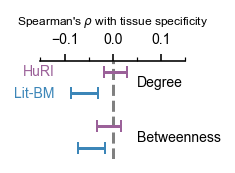

In [10]:
# betweenness and degree for hi and lit on one plot
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.3, 0.9)
ax.errorbar(x=[rhos['HI-III'][0], rhos_betw['HI-III'][0]],
            y=[3, 0.5],
            xerr=[[rhos['HI-III'][0] - rhos['HI-III'][1][0], rhos_betw['HI-III'][0] - rhos_betw['HI-III'][1][0]],
                  [rhos['HI-III'][1][1] - rhos['HI-III'][0], rhos['HI-III'][1][1] - rhos['HI-III'][0]]],
            fmt='none',
            capsize=3.,
            color=HURI_COLOR)
ax.errorbar(x=[rhos['Lit-BM-17'][0], rhos_betw['Lit-BM-17'][0]],
            y=[2, -0.5],
            xerr=[[rhos['Lit-BM-17'][0] - rhos['Lit-BM-17'][1][0], rhos_betw['Lit-BM-17'][0] - rhos_betw['Lit-BM-17'][1][0]],
                  [rhos['Lit-BM-17'][1][1] - rhos['Lit-BM-17'][0], rhos['Lit-BM-17'][1][1] - rhos['Lit-BM-17'][0]]],
            fmt='none',
            capsize=3.,
            color=LIT_COLOR)
ax.yaxis.set_tick_params(length=0, labelsize=7)
ax.set_yticks([])
ax.set_xlim((-0.15, 0.15))
ax.set_xticks([-0.15, -0.05, 0.05, 0.15], minor=True)
ax.axvline(0, linestyle='--', color='grey', zorder=0)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.set_xlabel(r"Spearman's $\rho$ with tissue specificity",
              fontsize=6)
ax.xaxis.set_label_position('top')

ax.text(-0.12, 3, 'HuRI', ha='right', va='center', color=HURI_COLOR, fontsize=7)
ax.text(-0.12, 2, 'Lit-BM', ha='right', va='center', color=LIT_COLOR, fontsize=7)
#ax.text(0.05, 2.5, ']', ha='right', va='center', color='black', fontsize=14)
ax.text(0.05, 2.5, 'Degree', ha='left', va='center', color='black', fontsize=7)
ax.text(0.05, 0., 'Betweenness', ha='left', va='center', color='black', fontsize=7)

ax.set_ylim(-1., 3.5)

for fmt in ['.pdf', '.png']:
    plt.savefig('../figures/TiP_degree_and_betweenness_correlations_with_CI' + fmt,
                bbox_inches='tight')